In [846]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from setup import get_task_data
import yfinance as yf

from sklearn.covariance import ShrunkCovariance
from scipy.optimize import minimize

from itertools import product

import random
SEED_VALUE = 42

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [847]:
financial_data = {}

# Stocks have different IPO date (first trade) so only last ~3 years of data used
HISTORY_SIZE = 1000
TARGET_STOCKS_COUNT = 20
INITIAL_FUND = 10000

stocks_df = pd.read_csv(get_task_data("StocksList.csv"))

stocks_list = stocks_df['Symbol'].astype(str).to_list()
stocks_list = list(map(lambda s: s.replace('^', '-'), stocks_list))
random.shuffle(stocks_list)

stocks_list = stocks_list[:TARGET_STOCKS_COUNT]

tickers = stocks_list
tickers_df = yf.download(tickers, period='5y')

[*********************100%%**********************]  20 of 20 completed


In [848]:
tickers_df = tickers_df.iloc[-HISTORY_SIZE:]

In [849]:
columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

def extract_history(tickers_df, stock):
    multiindex = pd.MultiIndex.from_product([columns, [stock]])
    stock_df = tickers_df[multiindex]

    stock_df.columns = stock_df.columns.to_flat_index()
    stock_df = stock_df.set_axis(columns, axis=1)
    stock_df = stock_df.dropna()
    return stock_df

In [850]:
for stock in stocks_list:    
    history = extract_history(tickers_df, stock)
    
    if len(history) < HISTORY_SIZE:
        print(f"Too short history: {len(history)}")
        continue
    
    financial_data[stock] = history.reset_index()[['Date', 'Close']].rename(columns={"Close": stock})

Too short history: 1
Too short history: 743
Too short history: 870
Too short history: 517
Too short history: 677
Too short history: 875
Too short history: 875


In [851]:
len(financial_data)

13

In [852]:
TRAIN_HISTORY = 800
TEST_HISTORY = 200

### 1 - Mean variance models, Efficient frontier 

In [853]:
def mean_historical_return(stock_prices, method='classic'):
    if method == 'classic':
        return stock_prices.pct_change().mean()
    if method == 'log':
        log_returns = np.log(stock_prices.pct_change().to_numpy() + 1)
        log_returns_df = pd.DataFrame(log_returns, columns=stock_prices.columns)
        return log_returns_df.mean()

def covariance(stock_prices, method='classic'):
    if method == 'classic':
        return stock_prices.pct_change().cov()
    if method == 'shrunk':
        arr = stock_prices.to_numpy()
        cov = ShrunkCovariance().fit(arr)
        shrunk_cov_df = pd.DataFrame(cov.covariance_ / len(stock_prices), columns=stock_prices.columns, index=stock_prices.columns)
        return shrunk_cov_df

def portfolio_performance(weights, mean_returns, cov_matrix, duration):
    returns = np.sum(mean_returns * weights) * duration
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)) * duration)
    return returns, std

In [854]:
def combine_stocks(stocks):
    df_merged = stocks[0][1]

    for (name, stock) in stocks[1:]:
        df_merged = pd.merge(df_merged,stock,on=['Date'], how='outer', suffixes=('', f'_{name}'))

    df_merged = df_merged.set_index('Date')
    return df_merged

In [855]:
portfolio = combine_stocks(list(financial_data.items()))
portfolio.columns

Index(['BPT', 'DAC', 'COP', 'STOK', 'COFS', 'VYX', 'HXL', 'CHT', 'FTNT',
       'LRCX', 'EVM', 'METC', 'DZSI'],
      dtype='object')

In [856]:
mean_returns = mean_historical_return(portfolio[:TRAIN_HISTORY])
log_returns = mean_historical_return(portfolio[:TRAIN_HISTORY], 'log')
cov_matrix = covariance(portfolio[:TRAIN_HISTORY])
shrunk_cov_matrix = covariance(portfolio[:TRAIN_HISTORY], 'shrunk')

In [857]:
def sharpe(weights, mean_returns, cov_matrix, risk_free = 0):
    returns, std = portfolio_performance(weights, mean_returns, cov_matrix, TRAIN_HISTORY)
    return (returns - risk_free) / std

def neg_sharpe(weights, mean_returns, cov_matrix, risk_free = 0):
    return -sharpe(weights, mean_returns, cov_matrix, risk_free)

def max_sharpe(mean_returns, cov_matrix, risk_free = 0, constraint_set=(0,1)):
    num_assets = len(mean_returns)
    
    args = (mean_returns, cov_matrix, risk_free)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    bound = constraint_set
    bounds = tuple(bound for _ in range(num_assets))
    
    result = minimize(neg_sharpe, num_assets*[1./num_assets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [858]:
def portfolio_variance(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix, TRAIN_HISTORY)[1]

def minimize_variance(mean_returns, cov_matrix, constraint_set=(0,1)):
    num_assets = len(mean_returns)
    
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    bound = constraint_set
    bounds = tuple(bound for _ in range(num_assets))
    
    result = minimize(portfolio_variance, num_assets*[1./num_assets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [859]:
def portfolio_return(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix, TRAIN_HISTORY)[0]

def efficient_portfolio(mean_returns, cov_matrix, return_target, constraint_set=(0,1)):
    num_assets = len(mean_returns)
    
    args = (mean_returns, cov_matrix)
    constraints = ({'type':'eq', 'fun': lambda x: portfolio_return(x, mean_returns, cov_matrix) - return_target},
                    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    bound = constraint_set
    bounds = tuple(bound for _ in range(num_assets))
    
    eff = minimize(portfolio_variance, num_assets*[1./num_assets], args=args, method = 'SLSQP', bounds=bounds, constraints=constraints)
    return eff

In [860]:
def efficient_frontier(mean_returns, cov_matrix, risk_free=0, constraint_set=(0,1)):
    max_sharpe_portfolio = max_sharpe(mean_returns, cov_matrix, risk_free, constraint_set).x
    ms_returns = portfolio_performance(max_sharpe_portfolio, mean_returns, cov_matrix, TRAIN_HISTORY)

    minimize_variance_portfolio = minimize_variance(mean_returns, cov_matrix, constraint_set).x
    mv_returns = portfolio_performance(minimize_variance_portfolio, mean_returns, cov_matrix)

    efficient_list = []
    target_returns = np.linspace(mv_returns, ms_returns, 20)
    for target in target_returns:
        efficient_list.append(efficient_portfolio(mean_returns, cov_matrix, target, constraint_set)['fun'])
    
    return efficient_list

In [861]:
def build_portfolio(initial_fund, weights):
    prices = portfolio.iloc[TRAIN_HISTORY].to_numpy()
    return ((initial_fund * weights) / prices).astype('int32')

In [862]:
def print_weights(portfolio, companies):
    for index, value in enumerate(portfolio):
        print(f'Recommended investment in {companies[index]} is {value} shares.')

In [863]:
def test_portfolio(stocks, weights):
    old_prices = portfolio.iloc[TRAIN_HISTORY].to_numpy()
    portfolio_initial_value = np.sum(stocks * old_prices)

    prices = portfolio.iloc[-1].to_numpy()
    portfolio_end_value = np.sum(stocks * prices)

    # ratio
    print(f'Initial: {portfolio_initial_value} End: {portfolio_end_value} Ratio: {portfolio_end_value / portfolio_initial_value}')

    # expected performance
    expected = portfolio_performance(weights, mean_returns, cov_matrix, TRAIN_HISTORY)

    mean_var_mean_returns = mean_historical_return(portfolio[TRAIN_HISTORY:])
    mean_var_cov_matrix = covariance(portfolio[TRAIN_HISTORY:])
    # actual performance
    actual = portfolio_performance(weights, mean_var_mean_returns, mean_var_cov_matrix, TEST_HISTORY)

    print(f'Expected: {expected}\n Actual: {actual}')

In [864]:
returns = [
    ('classic', mean_returns), 
    ('log', log_returns),
]

cov_matrices = [
    ('classic', cov_matrix), 
    ('shrunk', shrunk_cov_matrix),
]

test_data = list(product(returns, cov_matrices))

In [865]:
for (returns, cov) in test_data:
    print(returns[0], cov[0])

    weights = max_sharpe(returns[1], cov[1]).x
    result_portfolio = build_portfolio(INITIAL_FUND, weights)
    
    print(result_portfolio)
    test_portfolio(result_portfolio, weights)
    print('\n')

classic classic
[ 75  63   0   0   0   0   0   0  63   0   0 138   6]
Initial: 9960.750025749207 End: 10498.410282611847 Ratio: 1.0539778887606608
Expected: (2.040182173449133, 0.792347337353508)
 Actual: (0.07034926397516081, 0.23859165812152114)


classic shrunk
[261   0   0  76  20  16   0   0   4   0   0 304 162]
Initial: 9862.900929450989 End: 7771.759907245636 Ratio: 0.7879791110989336
Expected: (1.4763627090237723, 0.8691919371735215)
 Actual: (-0.38902782563336885, 0.3893937295124211)


log classic
[ 0 71  0  0  0  0  0  0 79  0  0 80  0]
Initial: 9891.720043182373 End: 10620.990352630615 Ratio: 1.0737253284832777
Expected: (2.0462138617949717, 0.8155114531792791)
 Actual: (0.11493817797234027, 0.23578938929413176)


log shrunk
[159   7   0   0   0   0   0   0  15   0   0 442 175]
Initial: 9970.930009841919 End: 9848.899936437607 Ratio: 0.9877614151053251
Expected: (1.7812019245058386, 0.9247587553109827)
 Actual: (-0.16995646982460344, 0.42997047266581173)




### The portfolio shows a positive return, but the actual performance in the testing period is lower than the expected performance based on historical data by a lot, that is one of the issue of mean variance models. It makes simple assumptions and its errors inflate over time. Also, logarithmiic return applies better in our case and shrunk covariance lower the model performance.

### 2 - Risk parity models

In [866]:
from sklearn.cluster import AgglomerativeClustering

In [867]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(portfolio.to_numpy().T)

In [868]:
from scipy.cluster.hierarchy import dendrogram

In [869]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, np.log(model.distances_), counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix, **kwargs)

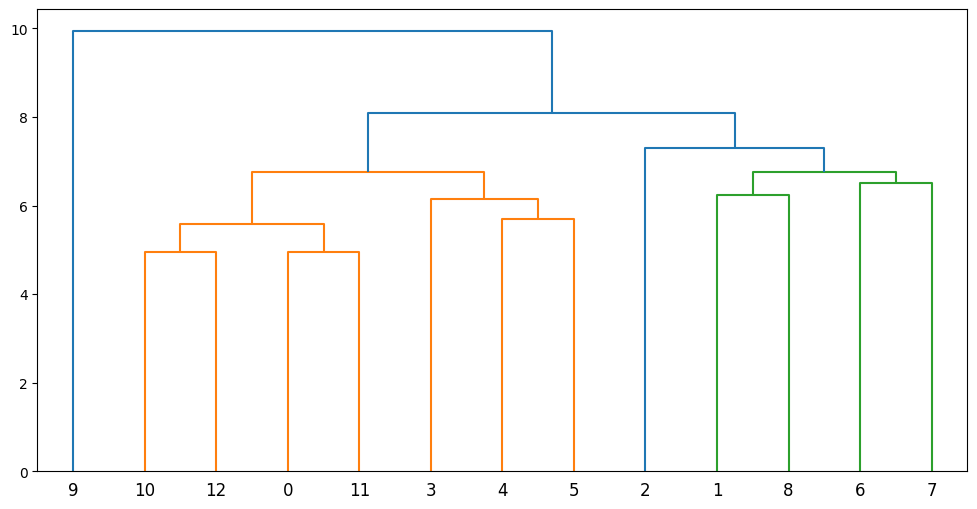

In [870]:
plot_dendrogram(model)

In [871]:
def hierarchical_risk_parity(portfolio):
    portfolio_arr = portfolio.to_numpy().T

    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(portfolio_arr)
    samples_count = len(portfolio.columns)

    subsets = {}
    weights = {}
    
    bisections = model.children_.tolist()
    clusters_count = len(bisections) + samples_count - 1

    def get_subset(index):
        if index < samples_count:
            return [index]
        else:
            return subsets[index]

    for i in range(len(bisections)):
        bisection = bisections[i]
        new_index = samples_count + i

        subsets[new_index] = get_subset(bisection[0]) + get_subset(bisection[1])

    bisections.reverse()
    weights[clusters_count] = 1 

    for i in range(len(bisections)):
        bisection = bisections[i]
        weight = weights[clusters_count - i]

        v1 = np.var(portfolio_arr[get_subset(bisection[0])])
        v2 = np.var(portfolio_arr[get_subset(bisection[1])])

        a1 = 1 - v1 / (v1 + v2)
        a2 = 1 - a1

        weights[bisection[0]] = a1 * weight
        weights[bisection[1]] = a2 * weight
    
    return np.array(list(map(lambda n: weights[n], range(0, samples_count))))

In [872]:
for (returns, cov) in test_data:
    print(returns[0], cov[0])

    weights = hierarchical_risk_parity(portfolio)
    result_portfolio = build_portfolio(INITIAL_FUND, weights)
    
    print(result_portfolio)
    test_portfolio(result_portfolio, weights)
    print('\n')

classic classic
[102   0   3  23  34  22   0  18   2   0 451 121  26]
Initial: 9437.27267742157 End: 8983.2201025486 Ratio: 0.9518873099895397
Expected: (0.5723377333822539, 0.43875303153492234)
 Actual: (-0.054742285546697134, 0.16465892624969133)


classic shrunk
[102   0   3  23  34  22   0  18   2   0 451 121  26]
Initial: 9437.27267742157 End: 8983.2201025486 Ratio: 0.9518873099895397
Expected: (0.5723377333822539, 0.43875303153492234)
 Actual: (-0.054742285546697134, 0.16465892624969133)


log classic
[102   0   3  23  34  22   0  18   2   0 451 121  26]
Initial: 9437.27267742157 End: 8983.2201025486 Ratio: 0.9518873099895397
Expected: (0.5723377333822539, 0.43875303153492234)
 Actual: (-0.054742285546697134, 0.16465892624969133)


log shrunk
[102   0   3  23  34  22   0  18   2   0 451 121  26]
Initial: 9437.27267742157 End: 8983.2201025486 Ratio: 0.9518873099895397
Expected: (0.5723377333822539, 0.43875303153492234)
 Actual: (-0.054742285546697134, 0.16465892624969133)




#### Based on Risk-Parity portfolio optimization technique, which is used to distribute weights across portfolio values to minimize the overall risk we got decrease in portfolio value, having 0.57% expected returns, but actually got -0.05. HRP approach performed worse for us, but its expectations were more realistic. We also can see that it does not depend on the metrics that other models use showing the same result for each input.

### 3 - Monte-Carlo modelling

In [873]:
def max_sharpe_monte_carlo(mean_returns, cov_matrix, iterations, risk_free = 0):
    num_assets = len(mean_returns)
    
    best_weights = None
    best_sharpe = 0

    for _ in range(iterations):
        weights = np.array(np.random.random(num_assets))
        # Rebalance Weights
        weights = weights / np.sum(weights)
    
        sharpe_index = sharpe(weights, mean_returns, cov_matrix, risk_free)
        if best_weights is None or best_sharpe < sharpe_index:
            best_weights = weights

    return best_weights

In [874]:
for (returns, cov) in test_data:
    print(returns[0], cov[0])

    weights = max_sharpe_monte_carlo(returns[1], cov[1], 5000)
    result_portfolio = build_portfolio(INITIAL_FUND, weights)
    
    print(result_portfolio)
    test_portfolio(result_portfolio, weights)
    print('\n')

classic classic
[ 84  12   2  74  50  56   5  37   9   1 100  76  35]
Initial: 9786.248368263245 End: 9100.39002251625 Ratio: 0.9299161108590673
Expected: (0.802172393517624, 0.5192462112261845)
 Actual: (-0.0937372158740913, 0.17154666306636765)


classic shrunk
[50 21 11 21 30 46 17 21  8  1 88 28 49]
Initial: 9466.079060554504 End: 9046.200095653534 Ratio: 0.9556438349801428
Expected: (0.9477749325975381, 0.5844078858650802)
 Actual: (-0.0689570170388577, 0.15155101087014797)


log classic
[ 78  23   1 130  43  42  15   9  12   0  87  97   0]
Initial: 9387.471283912659 End: 8847.530049800873 Ratio: 0.9424827818075902
Expected: (0.9872525334783682, 0.6117797645556882)
 Actual: (-0.02768894143007297, 0.19467314921232362)


log shrunk
[ 83  21   1  62   9  55  15  19   0   2 164  47  54]
Initial: 9405.591439247131 End: 8876.300094604492 Ratio: 0.9437258838998639
Expected: (0.9197380356261439, 0.5956708297879324)
 Actual: (-0.09547079910038204, 0.16552783649336764)




#### With Monte-Carlo approach, weights chosen are based on the simulation, aiming for the highest Sharpe ratio. Initially, random weights are chosen, then they are updated based on sharpe across iterations. Similar to the previous analyses, the portfolio value decreased, and the actual returns were negative during the testing period. The Monte Carlo optimization results in a portfolio with performance similar to the HRP model, indicating that both approaches may face challenges in the similar testing conditions. We also can see that there are no strict dependencies between arguments and results as it was in mean variance model.